Let's start out by searching iDigBio for all of the records that have an "associatedSequences" field.

In [2]:
import idigbio

api = idigbio.json()
seq_query = {"data.dwc:associatedSequences": {
            "type":"exists"
            }
        }
seq_count = api.count_records(rq=seq_query)
print seq_count

22161


It looks like only 22,161 records (out of 29,342,343 total records) have an entry for the "associatedSequences" field.

Now let's try and grab all of the entries so that we can start checking out counts and formats.

In [4]:
import csv

PAGE_SIZE = 1000
fields = ["data.dwc:associatedSequences", "recordset"]
seq_query = {"data.dwc:associatedSequences": {
            "type":"exists"
            }
        }

with open('idigbio_seqs_and_recordsets.tsv', 'wb') as outfile:
    tsvwriter = csv.writer(outfile, delimiter="\t")
    for offset in xrange(0,seq_count, PAGE_SIZE):
        seq_records = api.search_records(rq = seq_query, 
                                         limit=PAGE_SIZE, offset=offset, 
                                         fields=fields, fields_exclude=[])
        for seq_record in seq_records['items']:
            tsvwriter.writerow([seq_record['uuid'], 
                                seq_record['indexTerms']['recordset'], 
                                seq_record['data']['dwc:associatedSequences']])

In [7]:
import pandas as pd
import numpy as np

columns = ["specimen uuid", "recordset uuid","associatedSequence field"]
idigbio_sequences = pd.read_csv('idigbio_seqs_and_recordsets.tsv', names=columns, sep="\t", index_col=0)
print idigbio_sequences.head()

                                                            recordset uuid  \
specimen uuid                                                                
661df25d-8663-4dd2-a9fb-12941e55efe6  fcbcb214-cd62-4453-af56-b4b49161a261   
1b5e679a-ced4-45f7-83c6-d81ba72b6ea6  fcbcb214-cd62-4453-af56-b4b49161a261   
c6a0379d-6919-4624-a54f-0bf1c7e82318  fcbcb214-cd62-4453-af56-b4b49161a261   
01eb3840-f246-49aa-93ca-71400df1a044  fcbcb214-cd62-4453-af56-b4b49161a261   
ac37322c-276d-4fbc-80d8-680510a17d8c  fcbcb214-cd62-4453-af56-b4b49161a261   

                                                               associatedSequence field  
specimen uuid                                                                            
661df25d-8663-4dd2-a9fb-12941e55efe6  http://www.ncbi.nlm.nih.gov/nuccore/JN042326; ...  
1b5e679a-ced4-45f7-83c6-d81ba72b6ea6         http://www.ncbi.nlm.nih.gov/nuccore/U65280  
c6a0379d-6919-4624-a54f-0bf1c7e82318       http://www.ncbi.nlm.nih.gov/nuccore/GQ175238  
01e

In [8]:
import re

def pull_out_gb_accessions_and_count(seq_string):
    pattern = re.compile("[a-zA-Z]{1,2}\-?_?\d{5,6}")
    matching_accessions = re.findall(pattern, seq_string)
    if len(matching_accessions) > 0:
        gb_accs = "|".join(matching_accessions)
        return gb_accs, len(matching_accessions)
    return np.nan, 0

In [9]:
idigbio_sequences['extracted_accessions'], idigbio_sequences['sequence_count'] = \
    zip(*idigbio_sequences['associatedSequence field'].map(pull_out_gb_accessions_and_count))

In [10]:
print idigbio_sequences.head()

                                                            recordset uuid  \
specimen uuid                                                                
661df25d-8663-4dd2-a9fb-12941e55efe6  fcbcb214-cd62-4453-af56-b4b49161a261   
1b5e679a-ced4-45f7-83c6-d81ba72b6ea6  fcbcb214-cd62-4453-af56-b4b49161a261   
c6a0379d-6919-4624-a54f-0bf1c7e82318  fcbcb214-cd62-4453-af56-b4b49161a261   
01eb3840-f246-49aa-93ca-71400df1a044  fcbcb214-cd62-4453-af56-b4b49161a261   
ac37322c-276d-4fbc-80d8-680510a17d8c  fcbcb214-cd62-4453-af56-b4b49161a261   

                                                               associatedSequence field  \
specimen uuid                                                                             
661df25d-8663-4dd2-a9fb-12941e55efe6  http://www.ncbi.nlm.nih.gov/nuccore/JN042326; ...   
1b5e679a-ced4-45f7-83c6-d81ba72b6ea6         http://www.ncbi.nlm.nih.gov/nuccore/U65280   
c6a0379d-6919-4624-a54f-0bf1c7e82318       http://www.ncbi.nlm.nih.gov/nuccore/GQ175238  

In [16]:
print idigbio_sequences['sequence_count'].sum()

34185


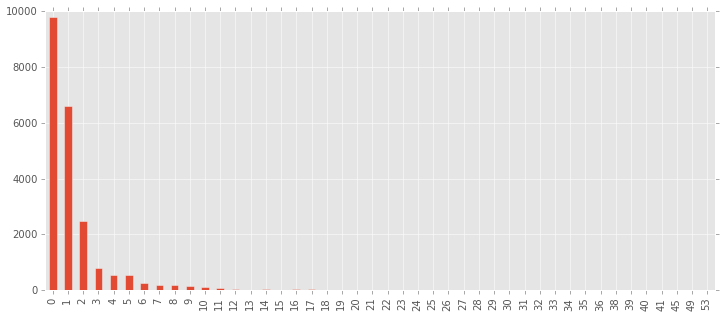

In [15]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 5

plt.style.use('ggplot')

vc = idigbio_sequences['sequence_count'].value_counts()
vc = vc.sort_index()

vc.plot(kind='bar')